### Summary

The goal of this project - construct a model, which will classify website reviews into Bad or Good 
Size of data sample - ~2 mln Amazon reviews in fastText format (kaggle dataset) 
I contructed three models on sentiment classification - fastText, XGBoost and RNN LSTM models.
As a target metric I chose ROC AUC.

The following results were achieved:
1. fastText: 90,91%
2. XGBoost: 85,91%
3. RNN LSTM: 91,97%

In conlusion, within the constraints of this project, I choose RNN LSTM model as the best due to the highest ROC AUC value.

Thoughts on improvement: RNN LSTM model could perform even better, if it was trained on the whole dataset (if only I had more computing power)

### Import libraries

In [2]:
from zipfile import ZipFile
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fasttext
import string
import re

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

Using TensorFlow backend.


In [ ]:
with ZipFile('fastText-0.9.1.zip', 'r') as fastText:
   # Extract all the contents of zip file in current directory
   fastText.extractall()

with ZipFile('train.ft.txt.bz2.zip', 'r') as train:
   # Extract all the contents of zip file in current directory
   train.extractall()
    
with ZipFile('test.ft.txt.bz2.zip', 'r') as test:
   # Extract all the contents of zip file in current directory
   test.extractall()

### Extract data

In [ ]:
f = open('test.ft.txt', 'r', encoding ='utf-8')
X_test = []
for i in f: 
    X_test.append(i[11:])
f.close()

In [1]:
f = open('test.ft.txt', 'r', encoding ='utf-8')
y_test = []
for i in f: 
    if i[:10] == '__label__1':
        y_test.append(0)
    else:
        y_test.append(1)
f.close()

In [ ]:
f = open('train.ft.txt', 'r', encoding ='utf-8')
X_train = []
for i in f: 
    X_train.append(i[11:])
f.close()

In [ ]:
f = open('train.ft.txt', 'r', encoding ='utf-8')
y_train = []
for i in f: 
    if i[:10] == '__label__1':
        y_train.append(0)
    else:
        y_train.append(1)
f.close()

### Building fastText classifier

In [ ]:
fasttext_model = fasttext.train_supervised('train.ft.txt')
fasttext_model.save_model("fasttext_model.bin")

In [ ]:
fasttext_model = fasttext.load_model("fasttext_model.bin")

In [ ]:
fasttext_pred = []
for i in range(len(X_test)):
    pred = fasttext_model.predict(X_test[i].rstrip())
    if pred[0] == ('__label__1',):
        fasttext_pred.append(0)
    else:
        fasttext_pred.append(1)
        
with open('fasttext_pred', 'wb') as f:
     pickle.dump(fasttext_pred, f)

In [3]:
with open('fasttext_pred', 'rb') as f:
     fasttext_pred = pickle.load(f)

In [4]:
fasttext_auc = roc_auc_score(y_test, fasttext_pred)

In [5]:
print ("SCORE:", fasttext_auc)

SCORE: 0.90911


### Building TFIDF + XGBoost classifier

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def Tokenizerr(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=Tokenizerr, stop_words=stop_words)

In [ ]:
train = vectorizer.fit_transform(X_train)

In [ ]:
test = vectorizer.transform(X_test)

In [ ]:
XGB_model = XGBClassifier()

In [ ]:
XGB_model.fit(XGB_train, y_train)

XGB_model.save_model("XGB_model.bin")

In [ ]:
XGB_model.load_model("XGB_model.bin")

In [ ]:
XGB_pred = XGB_model.predict(test)

with open('XGB_pred', 'wb') as f:
     pickle.dump(XGB_pred, f)

In [6]:
with open('XGB_pred', 'rb') as f:
     XGB_pred = pickle.load(f)

In [7]:
XGB_auc = roc_auc_score(y_test, XGB_pred)

In [8]:
print ("SCORE:", XGB_auc)

SCORE: 0.85914


### Building RNN LSTM classifier

#### Read data

In [ ]:
#Since I have limited computing power, I had to take twice less of the given dataset
train_data_len = int(len(X_train)*0.5)
test_data_len = int(len(X_test)*0.5)

In [ ]:
train_text = X_train[:train_data_len]
train_labels = y_train[:train_data_len]

In [ ]:
test_text = X_test[:test_data_len]
test_labels = y_test[:test_data_len]

In [ ]:
print('Train len: '+ str(len(train_labels)))
print('Test len: '+ str(len(test_labels)))

In [ ]:
train_data = pd.DataFrame(list(zip(train_text, train_labels)))
train_data.columns = {'text', 'labels'}

In [ ]:
test_data = pd.DataFrame(list(zip(test_text, test_labels)))
test_data.columns = {'text', 'labels'}

#### Clean train & test data

In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

In [ ]:
train_data['Text_Clean'] = train_data['text'].apply(lambda x: remove_punct(x))

In [ ]:
test_data['Text_Clean'] = test_data['text'].apply(lambda x: remove_punct(x))

In [ ]:
train_tokens = [word_tokenize(sen) for sen in train_data.Text_Clean]

In [ ]:
test_tokens = [word_tokenize(sen) for sen in test_data.Text_Clean]

In [ ]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]

In [ ]:
lower_train_tokens = [lower_token(token) for token in train_tokens]

In [ ]:
lower_test_tokens = [lower_token(token) for token in test_tokens]

In [ ]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stop_words]

In [ ]:
filtered_train_words = [removeStopWords(sen) for sen in lower_train_tokens]

In [ ]:
filtered_test_words = [removeStopWords(sen) for sen in lower_test_tokens]

In [ ]:
train_data['Text_Final'] = [' '.join(sen) for sen in filtered_train_words]
train_data['tokens'] = filtered_train_words

In [ ]:
test_data['Text_Final'] = [' '.join(sen) for sen in filtered_test_words]
test_data['tokens'] = filtered_test_words

In [ ]:
pos = []
neg = []

for l in train_data.labels:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
        
train_data['Pos']= pos
train_data['Neg']= neg

train_data = train_data[['Text_Final', 'tokens', 'labels', 'Pos', 'Neg']]
train_data.head()

with open('train_data', 'wb') as f:
     pickle.dump(train_data, f)

In [ ]:
pos = []
neg = []

for l in test_data.labels:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
        
test_data['Pos']= pos
test_data['Neg']= neg

test_data = test_data[['Text_Final', 'tokens', 'labels', 'Pos', 'Neg']]
test_data.head()

with open('test_data', 'wb') as f:
     pickle.dump(test_data, f)

In [9]:
with open('train_data', 'rb') as f:
     train_data = pickle.load(f)
        
with open('test_data', 'rb') as f:
     test_data = pickle.load(f)

In [10]:
print(test_data.head())

                                          Text_Final  \
0  great cd lovely pat one great voices generatio...   
1  one best game music soundtracks game didnt rea...   
2  batteries died within year bought charger jul ...   
3  works fine maha energy better check maha energ...   
4  great nonaudiophile reviewed quite bit combo p...   

                                              tokens  labels  Pos  Neg  
0  [great, cd, lovely, pat, one, great, voices, g...       1    1    0  
1  [one, best, game, music, soundtracks, game, di...       1    1    0  
2  [batteries, died, within, year, bought, charge...       0    0    1  
3  [works, fine, maha, energy, better, check, mah...       1    1    0  
4  [great, nonaudiophile, reviewed, quite, bit, c...       1    1    0  


In [11]:
print(train_data.head())

                                          Text_Final  \
0  stuning even nongamer sound track beautiful pa...   
1  best soundtrack ever anything im reading lot r...   
2  amazing soundtrack favorite music time hands i...   
3  excellent soundtrack truly like soundtrack enj...   
4  remember pull jaw floor hearing youve played g...   

                                              tokens  labels  Pos  Neg  
0  [stuning, even, nongamer, sound, track, beauti...       1    1    0  
1  [best, soundtrack, ever, anything, im, reading...       1    1    0  
2  [amazing, soundtrack, favorite, music, time, h...       1    1    0  
3  [excellent, soundtrack, truly, like, soundtrac...       1    1    0  
4  [remember, pull, jaw, floor, hearing, youve, p...       1    1    0  


#### Getting Vocabulary

In [ ]:
all_training_words = [word for tokens in train_data["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in train_data["tokens"]]
training_vocab = sorted(list(set(all_training_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(training_vocab)))
print("Max sentence length is %s" % max(training_sentence_lengths))

In [ ]:
all_test_words = [word for tokens in test_data["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in test_data["tokens"]]
test_vocab = sorted(list(set(all_test_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(test_vocab)))
print("Max sentence length is %s" % max(test_sentence_lengths))

#### Tokenize and Pad sequences

In [ ]:
tokenizer = Tokenizer(num_words=len(training_vocab), lower=True, char_level=False, oov_token=True)
tokenizer.fit_on_texts(train_data["Text_Final"].tolist())

In [ ]:
train_word_index = tokenizer.word_index
print("Found %s unique tokens." % len(train_word_index))

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_data["Text_Final"].tolist())
train_rnn_data = pad_sequences(training_sequences, maxlen=150)

In [ ]:
with open('train_rnn_data', 'wb') as f:
     pickle.dump(train_rnn_data, f)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_data["Text_Final"].tolist())
test_rnn_data = pad_sequences(test_sequences, maxlen=150)

with open('test_rnn_data', 'wb') as f:
     pickle.dump(test_rnn_data, f)

#### Define RNN-LSTM

In [13]:
label_names = ['Pos', 'Neg']

In [14]:
with open('train_rnn_data', 'rb') as f:
     x_tr = pickle.load(f)
        
y_tr = train_data[label_names].values

In [15]:
embed_dim = 128
max_fatures = 2000

rnn_model = Sequential()
rnn_model.add(Embedding(max_fatures, embed_dim, input_length = x_tr.shape[1]))
rnn_model.add(SpatialDropout1D(0.4))

rnn_model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))

rnn_model.add(Dense(2,activation='softmax'))

rnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(rnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Create a file with RNN weights
filename = "rnn_model.hdf5"
filepath = "rnn_model.hdf5"

In [ ]:
callbacks = [ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')]

In [ ]:
hist = rnn_model.fit(x_tr, y_tr, epochs=20, batch_size=512, callbacks=callbacks)

with open('hist', 'wb') as f:
     pickle.dump(hist, f)

In [17]:
with open('hist', 'rb') as f:
     hist = pickle.load(f)

C:\Users\danil\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
#Loading pre-trained weights
rnn_model.load_weights(filename)

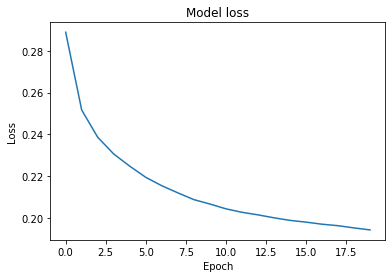

In [18]:
# Plot loss values
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
with open('test_rnn_data', 'rb') as f:
     x_te = pickle.load(f)

In [ ]:
y_te = test_data[label_names].values

In [ ]:
rnn_pred = rnn_model.predict(x_te, batch_size=512, verbose=1)

In [ ]:
rnn_pred_label = []
for i in rnn_pred:
    if i[0]>i[1]:
        rnn_pred_label.append(1)
    else:
        rnn_pred_label.append(0)
        
with open('rnn_pred_label', 'wb') as f:
     pickle.dump(rnn_pred_label, f)

In [19]:
with open('rnn_pred_label', 'rb') as f:
     rnn_pred_label = pickle.load(f)
        
y_label = test_data['labels'].values

In [20]:
rnn_auc = roc_auc_score(y_label, rnn_pred_label)

In [21]:
print ("SCORE:", rnn_auc)

SCORE: 0.9197318438897866
